# Q Learning
Reference: https://github.com/dennybritz/reinforcement-learning/blob/master/TD/Q-Learning%20Solution.ipynb

In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import time

from collections import defaultdict
from gridworld import GridworldEnv
from cliff_walking import CliffWalkingEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
mdp = 'grid_world'  # Set to the mdp problem to solve
assert mdp in {'grid_world', 'cliff_walking'}
if mdp == 'grid_world':
    env = GridworldEnv(shape=[4, 4])
else:
    env = CliffWalkingEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [4]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    
    return Q, stats

In [5]:
start_time = time.time()
Q, stats = q_learning(env, 500)
end_time = time.time()
print('Time elapsed: {} seconds'.format(end_time - start_time))

Episode 500/500.Time elapsed: 0.09518694877624512 seconds


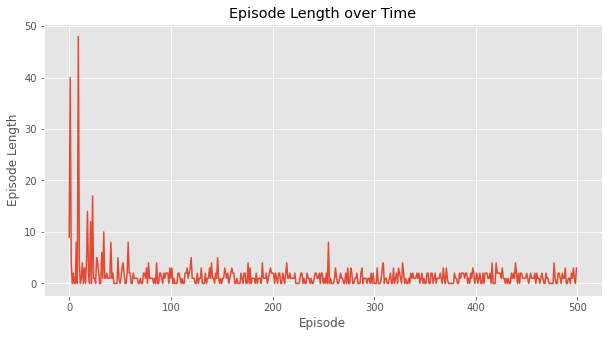

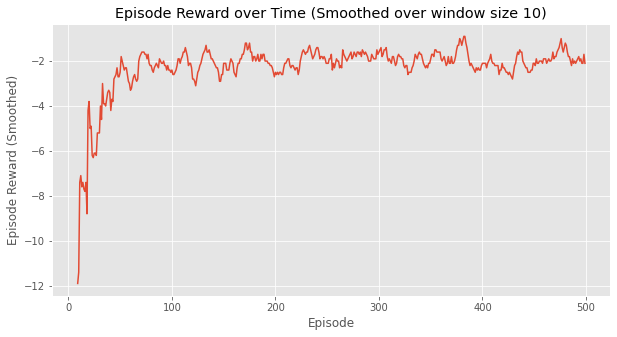

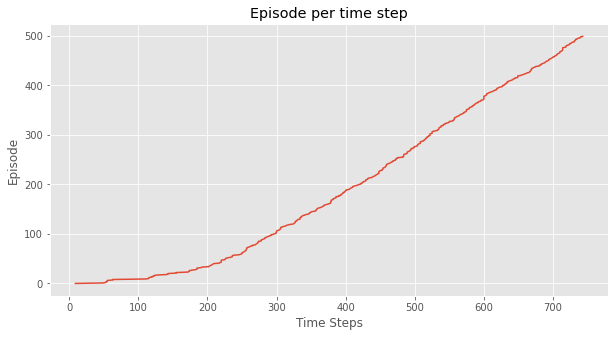

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [6]:
plotting.plot_episode_stats(stats)

In [7]:
q_values = np.vstack(tuple(Q[k] for k in sorted(Q.keys())))

print("Q (state-action) values:")
print(q_values)

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(q_values, axis=1), env.shape))

print("Value Function:")
print(np.max(q_values, axis=1))

print("Reshaped Grid Value Function:")
print(np.max(q_values, axis=1).reshape(env.shape))

Q (state-action) values:
[[ 0.          0.          0.          0.        ]
 [-1.984375   -2.78014718 -1.99909196 -1.        ]
 [-2.         -2.40625    -3.59779239 -2.        ]
 [-3.25       -3.25       -2.9998573  -2.99988263]
 [-1.         -2.77232321 -2.85936463 -1.98431396]
 [-2.         -3.51355093 -3.67225477 -2.        ]
 [-2.99510776 -2.9964514  -2.99649532 -2.99722797]
 [-2.         -2.75       -2.         -3.23185266]
 [-2.         -3.49586221 -3.42426215 -2.93749968]
 [-2.99830366 -2.99835342 -2.99888408 -2.999225  ]
 [-2.73193359 -1.99999999 -1.99999999 -3.00245094]
 [-2.73382469 -1.875      -1.         -2.76561175]
 [-2.99999921 -2.9999986  -3.74817474 -3.6249986 ]
 [-3.07269287 -2.         -2.875      -3.63861553]
 [-2.28124993 -1.         -1.99212646 -2.94189097]
 [ 0.          0.          0.          0.        ]]
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 3 0 2]
 [0 0 2 2]
 [1 1 1 0]]
Value Function:
[ 0.         -1.         -2.         -2.999